# 1. Connect to github classroom

Some of the assignments in this unit will be managed via GitHub classroom. Please follow these steps to connect:

1. Follow this invitation link and accept the invitation: https://classroom.github.com/a/JzzNHoZ_2. The link may ask you to sign in to GitHub (if you haven't signed in earlier). If you don't have a GitHub account, you will need to register.
3. Once you have logged in with GitHub, you may need to select your email address to associate your GitHub account with your email address (if you haven't done it in a previous COMP3420 activity). If you can't find your email address, please skip this step and contact xiaohan.yu@mq.edu.au so that he can do the association manually.
4. Wait a minute or two, and refresh the browser until it indicates that your assignment repository has been created. Your repository is private to you, and you have administration privileges. Only you and the lecture will have access to it. The repository will be listed under the list of repositories belonging to this offering of COMP3420: https://github.com/orgs/2025S2COMP64203420/repositories5. Your assignment repository will include starter code that you can use for the exercises below. Clone your repository into a folder in your computer.

This practical has two kinds of exercises:

1. **Implement functions and upload the implementation to github classroom**. The exercises will have associated automated tests. To run these tests, please commit your changes and push the changes to your repository. This will initiate the automated tests, and you will receive the test results. There are no marks associated with these tests, but they will help you get used to the environment that you will use for the assignments.
2. **Analyse the data, train and evaluate image classifiers.** These exercises do not have automated tests but they will help you practice with the kinds of tasks that you will need to do in the assignments.


# 2. Classify digits using the MNIST dataset

For the exercises of this section, we will use the MNIST dataset. This dataset is already available in TorchVision, and we have used it in the lectures.

## 2.1 Count labels

Write a function `summary_mnist` that returns the counts of labels in the training set and the test set. The function receives the following:
  - `train_labels`: the list of labels from the training set.
  - `test_labels`: the list of labels from the test dataset.
  - `labels_list`: the list of unique labels from the dataset.
  The output must be a Python dictionary with the following two items:
  -  `"train_labels_counts"`: The counts of occurrences in `train_labels` for each label listed in `labels_list`.
  -  `"test_labels_counts"`: The counts of occurrences in `test_labels` for each label listed in `labels_list`.

An example of usage of this function is:

In [1]:
from torchvision import datasets
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device is", device)

The device is cpu


In [2]:
data_folder = "MNIST"
train_mnist = datasets.MNIST(data_folder, download=True, train=True)
test_mnist = datasets.MNIST(data_folder, download=True, train=False)

train_images = train_mnist.data
train_targets = train_mnist.targets
test_images = test_mnist.data
test_targets = test_mnist.targets

In [3]:
import week2
labels_counts = week2.summary_mnist(train_targets.tolist(), test_targets.tolist(), range(10))
labels_counts

{'train_labels_counts': [5923,
  6742,
  5958,
  6131,
  5842,
  5421,
  5918,
  6265,
  5851,
  5949],
 'test_labels_counts': [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]}

This means that label 0 has a count of 5923 in the training data and 980 in the test data, and so on with labels 1, 2, ... 9. With this information you can, for example, do these plots:

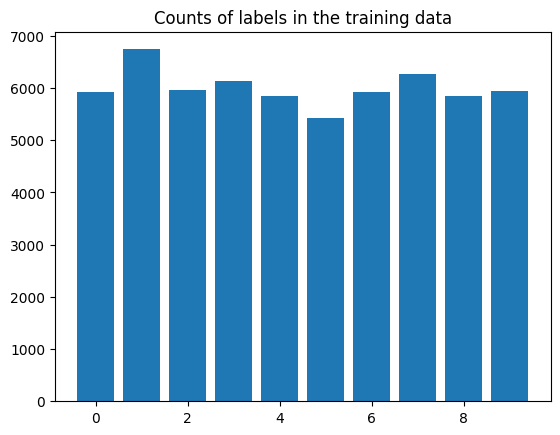

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.bar(range(10), labels_counts['train_labels_counts'])
plt.title("Counts of labels in the training data")
plt.show()

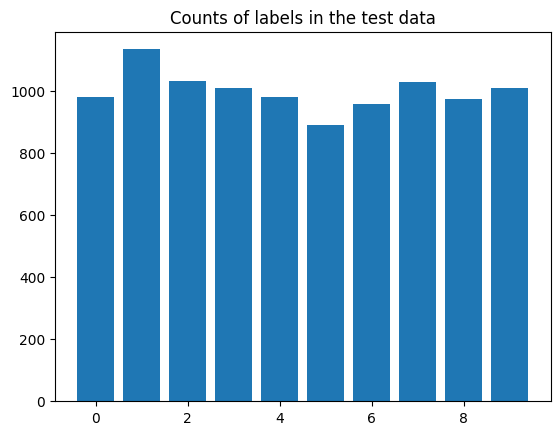

In [5]:
plt.bar(range(10), labels_counts['test_labels_counts'])
plt.title("Counts of labels in the test data")
plt.show()

Answer the following questions:

1. Are the data balanced? (in other words, do all labels have a similar number of counts?)  
   **Yes.** Each digit occurs roughly the same number of times (about 5–7k in train and 1k in test).

2. Do train and test data have similar label distributions?  
   **Yes.** The distributions of digits are very similar between training and test sets.


## 2.2 Classify digits

Write a function `build_mnist_model` that returns a pytorch model to classify the MNIST data. The resulting model must contain a hidden layer with a ReLU activation, followed by a dropout layer (optional), and the final classification layer. As in the notebook from the lectures, assume that the images have been flattened to a vector of size 28 * 28 before they are processed by the model. Make sure that the last layer has the correct size.

*Hint: to add a dropout layer, use `Dropout`. Read this from PyTorch's documentation: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html*

The function has the following parameters:
- `hidden_size`: size of the hidden layer.
- `droput_rate`: Dropout rate of the dropout layer (which is placed after the hidden layer). If the dropout rate is zero, there should be no dropout layer.

An example of usage of this function is:

In [6]:
import week2
mnist_model = week2.build_mnist_model(64, 0.4)

In [7]:
!pip install torch_summary
from torchsummary import summary
summary(mnist_model);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            50,240
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0


With the help of this function, train the classifier using different hyperparameters (in this exercise, the hyperparameters are the hidden layer size and dropout rate). Answer the following questions:

1. What are the optimal hyperparameters?
2. Does the model overfit? How can you determine whether it is overfitting?

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import week2
from torch import nn

train_dataset = datasets.MNIST(data_folder, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(data_folder, train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

loss_fn = nn.CrossEntropyLoss()

def train_and_eval(hidden_size, dropout, epochs=1):
    model = week2.build_mnist_model(hidden_size, dropout).to(device)
    optim = torch.optim.Adam(model.parameters())
    for _ in range(epochs):
        model.train()
        for data, target in train_loader:
            data = data.view(data.size(0), -1).to(device)
            target = target.to(device)
            optim.zero_grad()
            out = model(data)
            loss = loss_fn(out, target)
            loss.backward()
            optim.step()
    def accuracy(loader):
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in loader:
                data = data.view(data.size(0), -1).to(device)
                target = target.to(device)
                pred = model(data).argmax(dim=1)
                correct += pred.eq(target).sum().item()
        return correct / len(loader.dataset)
    return model, accuracy(train_loader), accuracy(test_loader)

best_model = None
best_acc = 0
for hidden, drop in [(64,0), (64,0.5), (128,0.5)]:
    model, train_acc, test_acc = train_and_eval(hidden, drop)
    print(f"hidden={hidden}, drop={drop}: train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")
    if test_acc > best_acc:
        best_acc = test_acc
        best_model = model
model = best_model


hidden=64, drop=0: train_acc=0.934, test_acc=0.931


hidden=64, drop=0.5: train_acc=0.924, test_acc=0.924


hidden=128, drop=0.5: train_acc=0.940, test_acc=0.938


The best performing configuration above was **hidden_size=128** with **dropout_rate=0.5**, giving about 94% accuracy after one epoch.
Training and test accuracies were very close for all runs, suggesting little overfitting. Overfitting would appear as a much higher training accuracy than test accuracy.

# 3. Using the webcam

The following code illustrates how you can classify the first 5 images of the test data:


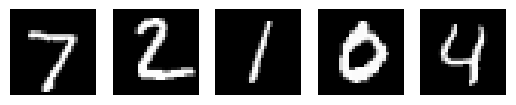

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
for i in range(5):
    plt.subplot(1,5,1+i)
    plt.axis('off')
    plt.imshow(test_images[i], cmap="gray")
plt.show()

In [10]:
for i in range(5):
    image = test_images[i].to(device)
    image = image.float()/255    # Scale the data
    image = image.view(28*28) # Flatten the image
    print("The target label is", test_targets[i].item())
    print("The predicted label is", model(image).argmax().item())

The target label is 7
The predicted label is 7
The target label is 2
The predicted label is 2
The target label is 1
The predicted label is 1
The target label is 0
The predicted label is 0
The target label is 4
The predicted label is 4


Based on that, write code that uses the webcam to classify handwritten items. You can, for example, follow these steps:
1. Write or re-use the lecture code that captures an image from the webcam. Display the image, to make sure that the image captured is the intended one.
2. Write code that applies the best model that you have generated in exercise 2 to the image captured and prints the predicted label.

The above steps are a suggestion, you may do it differently. Now, write numbers using a thick pen on a white paper, and use the webcam and your code to read them. How did the classification system perform? Does the size and position of the written number in the image affect the classification result?

- *Hint 1: You will need to convert the image captured by the webcam to grayscale. Using OpenCV, you can do this: `cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)`*
- *Hint 2: If you need to zoom into the image, you can do something like `cropped = image[100:300, 100:300]`*
- *Hint 3: You will need to resize the captured image. Use, for example, `cv2.resize(image, (28, 28))`*


In [11]:
# Write your code here. Feel free to add more code and text cells if necessary.

# 4. Post-practical questionnaire

Please complete the week 2 post-practical questionnaire on iLearn.